In [46]:
import torch
import torchvision
import torchvision.transforms as transforms

In [47]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


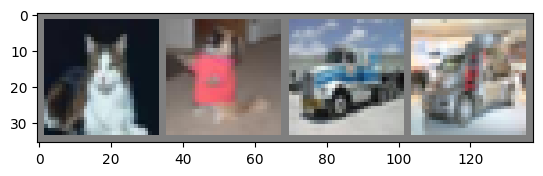

cat   dog   truck car  


In [48]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt
import numpy as np 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.pool = nn.MaxPool2d(2, 2) # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input image channel, 16 output channels, 5x5 square convolution kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # an affine operation: y = Wx + b
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 outputs for 10 classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Max pooling over a (2, 2) window
        x = self.pool(F.relu(self.conv2(x))) # Max pooling over a (2, 2) window
        x = x.view(-1, 16 * 5 * 5) # reshape
        x = F.relu(self.fc1(x)) # an affine operation: y = Wx + b
        x = F.relu(self.fc2(x)) # an affine operation: y = Wx + b
        x = self.fc3(x) # an affine operation: y = Wx + b
        return x

net = Net()

In [55]:

import torch.optim as optim
criterion = nn.CrossEntropyLoss() # a classification cross-entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # stochastic gradient descent (SGD) with momentum
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce GTX 1060


In [51]:
import time
start = time.time()
net.to(device) # without GPU 117 sec
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() # zero the parameter gradients
        outputs = net(inputs) # forward + backward + optimize
        loss = criterion(outputs, labels) # a classification cross-entropy loss
        loss.backward() # backward
        optimizer.step() # optimize
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
endtime = time.time()
print(f'Training time: {endtime - start:.3f} seconds')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.186
[1,  4000] loss: 1.886
[1,  6000] loss: 1.696
[1,  8000] loss: 1.618
[1, 10000] loss: 1.533
[1, 12000] loss: 1.486
[2,  2000] loss: 1.426
[2,  4000] loss: 1.394
[2,  6000] loss: 1.351
[2,  8000] loss: 1.349
[2, 10000] loss: 1.320
[2, 12000] loss: 1.293
Finished Training
Training time: 241.756 seconds


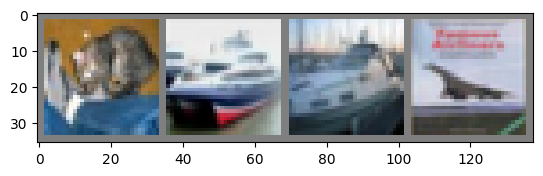

GroundTruth:  cat   ship  ship  plane


In [56]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [57]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [58]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %
